In [ ]:
#| hide
!pip install -Uqq nixtla

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Introduction to Online (Real-Time) Anomaly Detection
In this notebook, we introduce the `detect_anomalies_online` method. You will learn how to quickly start using this new endpoint and understand its key differences from the historical anomaly detection endpoint. New features include:
* More flexibility and control over the anomaly detection process
* Perform univariate and multivariate anomaly detection
* Detect anomalies on stream data

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/capabilities/online-anomaly-detection/01_quickstart')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/capabilities/online-anomaly-detection/01_quickstart.ipynb)

In [ ]:
import pandas as pd
from nixtla import NixtlaClient
import matplotlib.pyplot as plt

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
> 
> To use an Azure AI endpoint, set the `base_url` argument:
> 
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 1. Dataset
In this notebook, we use a minute-level time series dataset that monitors server usage. This is a good example of a streaming data scenario, as the task is to detect server failures or downtime.

In [ ]:
df = pd.read_csv('https://datasets-nixtla.s3.us-east-1.amazonaws.com/machine-1-1.csv', parse_dates=['ts'])

We observe that the time series remains stable during the initial period; however, a spike occurs in the last 20 steps, indicating an anomalous behavior. Our goal is to capture this abnormal jump as soon as it appears. Let's see how the real-time anomaly detection capability of TimeGPT performs in this scenario!

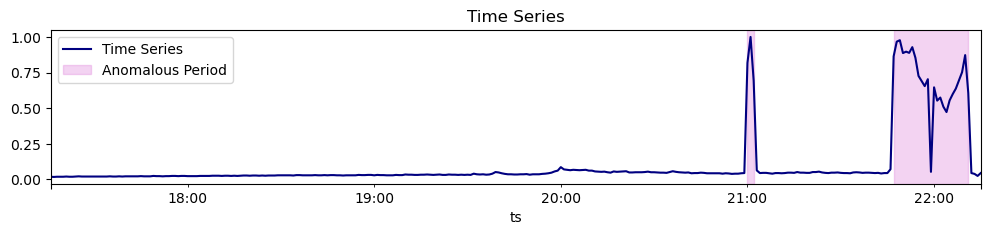

In [ ]:
#| echo: false
ax = df.tail(300).plot(x='ts', y='y', color = 'navy', title='Time Series', figsize=(12, 2))
plt.axvspan('2020-02-01 21:00:00', '2020-02-01 21:02:00', color='orchid', alpha=0.3, label='Anomalous Period')
plt.axvspan('2020-02-01 21:47:00', '2020-02-01 22:11:00', color='orchid', alpha=0.3)
ax.legend(['Time Series', 'Anomalous Period'])
plt.show()

## 2. Detect anomalies in real time
The `detect_anomalies_online` method detect anomalies in a time series leveraging TimeGPT's forecast power. It uses the forecast error in deciding the anomalous step so you can specify and tune the parameters like that of the `forecast` method. This function will return a dataframe that contains anomaly flags and anomaly score (its absolute value quantifies the abnormality of the value).

To perfom real-time anomaly detection, set the following parameters:

- `df`: A pandas DataFrame containing the time series data.
- `time_col`: The column that identifies the datestamp.
- `target_col`: The variable to forecast.
- `h`: Horizon is the number of steps ahead to make forecast.
- `freq`: The frequency of the time series in Pandas format.
- `level`: Percentile of scores distribution at which the threshold is set, controlling how strictly anomalies are flagged. Default at 99%.
- `detection_size`: The number of steps to analyze for anomaly at the end of time series.

In [ ]:
anomaly_online = nixtla_client.detect_anomalies_online(
    df,
    time_col='ts',                  
    target_col='y',                 
    freq='min',                     # Specify the frequency of the data
    h=10,                           # Specify the forecast horizon
    level=99,                       # Set the confidence level for anomaly detection
    detection_size=100              # How many steps you want for analyzing anomalies
)
anomaly_online.tail()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Online Anomaly Detector Endpoint...


,unique_id,ts,y,TimeGPT,anomaly,anomaly_score,TimeGPT-hi-99,TimeGPT-lo-99
95,machine-1-1_y_29,2020-02-01 22:11:00,0.606017,0.544625,True,18.463266,0.553161,0.536090
96,machine-1-1_y_29,2020-02-01 22:12:00,0.044413,0.570869,True,-158.933850,0.579404,0.562333
97,machine-1-1_y_29,2020-02-01 22:13:00,0.038682,0.560303,True,-157.474880,0.568839,0.551767
98,machine-1-1_y_29,2020-02-01 22:14:00,0.024355,0.521797,True,-150.178240,0.530333,0.513261
99,machine-1-1_y_29,2020-02-01 22:15:00,0.044413,0.467860,True,-127.848560,0.476396,0.459325


> 📘 In this example, we use a detection size of 100 to illustrate the anomaly detection process. In practice, using a smaller detection size and running the detection more frequently improves granularity and enables more timely identification of anomalies as they occur.

From the plot, we observe that both anomalous periods were detected right as they arose. For further methods on improving detection accuracy and customizing anomaly detection, read our other tutorials on online anomaly detection.

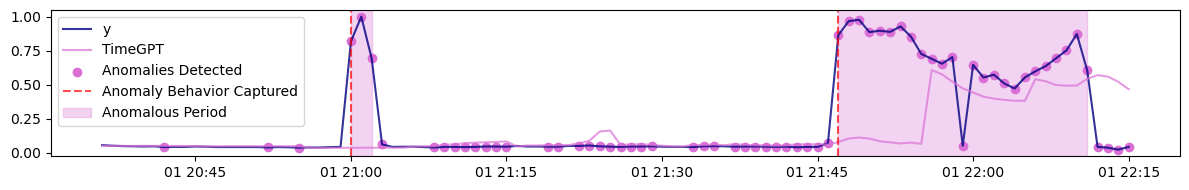

In [ ]:
#| echo: false
plt.figure(figsize=(12, 2))
plt.plot(anomaly_online['ts'], anomaly_online['y'], label='y', color='navy', alpha=0.8)
plt.plot(anomaly_online['ts'], anomaly_online['TimeGPT'], label='TimeGPT', color='orchid', alpha=0.7)
plt.scatter(anomaly_online.loc[anomaly_online['anomaly'], 'ts'], anomaly_online.loc[anomaly_online['anomaly'], 'y'], color='orchid', label='Anomalies Detected')
for t in ['2020-02-01 21:00:00', '2020-02-01 21:47:00']:
    plt.axvline(pd.to_datetime(t), color='red', linestyle='--', alpha=0.7, label='Anomaly Behavior Captured' if t == '2020-02-01 21:00:00' else None)

plt.axvspan('2020-02-01 21:00:00', '2020-02-01 21:02:00', color='orchid', alpha=0.3, label='Anomalous Period')
plt.axvspan('2020-02-01 21:47:00', '2020-02-01 22:11:00', color='orchid', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

For an in-depth analysis of the `detect_anomalies_online` method, refer to the tutorial (coming soon).